<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Parking_spot_detection_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import json
import pickle
import shutil
import sklearn
import skimage
import zipfile
import IPython
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn import svm
import tensorflow_datasets
from sklearn import metrics
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn import model_selection

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d blanderbuss/parking-lot-dataset
!unzip \*.zip && rm *.zip
IPython.display.clear_output()

#Image Classifier
At first we need to create a model to predict if a spot shown in the image is Empty or Occupied.

We use the [**parking lot dataset**](https://www.kaggle.com/datasets/blanderbuss/parking-lot-dataset) from kaggle for both classification and detection tasks.

###Data

In [10]:
cls_data = './PKLot/PKLotSegmented'
train_path = './data/train'
val_path   = './data/validation'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

VAL_THRESHOLD = 0.2

In [11]:
#since the models are big so we need to select only a portion of the data so the ram won't get fulled
limit = 80
data_arr = []

for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O)[:limit]:
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = train_path if np.random.randn()<VAL_THRESHOLD else val_path
          target = os.path.join(folder_name, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)


data = pd.DataFrame(data_arr, columns=['path', 'label'])
data

,path,label
0,./data/validation/2012-10-30_11_22_09#091.jpg,1
1,./data/train/2012-10-30_10_22_06#091.jpg,1
2,./data/train/2012-10-30_16_22_22#092.jpg,1
3,./data/validation/2012-10-30_14_37_17#091.jpg,1
4,./data/train/2012-10-30_15_17_19#092.jpg,1
...,...,...
18123,./data/validation/2013-01-21_10_25_05#004.jpg,1
18124,./data/train/2013-01-21_10_10_05#003.jpg,1
18125,./data/train/2013-01-21_08_35_04#025.jpg,1
18126,./data/validation/2013-01-21_10_20_05#005.jpg,1


In [12]:
data.groupby(['label']).count()

,path
label,
0,9376
1,8752


In [13]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory('./data',
                                                               validation_split=0.2,
                                                               subset='both',
                                                               seed=32,
                                                               image_size=(150, 150),
                                                               batch_size=32)

Found 38113 files belonging to 2 classes.
Using 30491 files for training.
Using 7622 files for validation.


### Visualization

In [14]:
def show_images(ds, augmentation=False):
  plt.figure(figsize=(3, 3))
  for images, labels in ds.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          if augmentation:
            images = data_augmentation(images)
            i = 0
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(int(labels[i]))
          plt.axis("off")

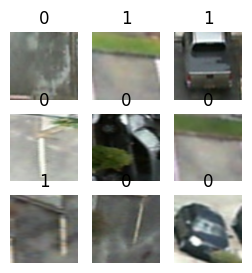

In [15]:
show_images(train_ds)

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
    ], name="img_augmentation")

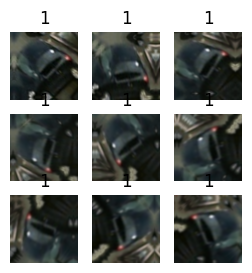

In [17]:
show_images(train_ds, augmentation=True)

In [18]:
augmented_train_ds = train_ds.map(lambda img, label : (data_augmentation(img), label),
                                  num_parallel_calls=tf.data.AUTOTUNE)

#(buffered) Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

In [19]:
def plot_hist(hist, acc='binary_accuracy'):
    plt.plot(hist.history[f"{acc}"])
    plt.plot(hist.history[f"val_{acc}"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Model 1:
**Yolo V8**

Since the Yolo model needs some special data directory order, we need to change the data directory


In [ ]:
#install necessary libraries
!pip install awscli
!pip install ultralytics

import ultralytics
IPython.display.clear_output()

In [ ]:
cls_data = './PKLot/PKLotSegmented'
train_path_1 = './data/train/Empty/'
train_path_2 = './data/train/Occupied/'
val_path_1   = './data/validation/Empty/'
val_path_2   = './data/validation/Occupied/'

os.makedirs(train_path_1, exist_ok=True)
os.makedirs(val_path_1, exist_ok=True)
os.makedirs(train_path_2, exist_ok=True)
os.makedirs(val_path_2, exist_ok=True)

VAL_THRESHOLD = 0.2
data_arr = []
limit = 40


data = pd.DataFrame(data_arr, columns=['path', 'label'])
for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O)[:limit]:
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = 'train' if np.random.randn()<VAL_THRESHOLD else 'validation'
          target = os.path.join('./data', folder_name, E_O, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)
          break

data = pd.DataFrame(data_arr, columns=['path', 'label'])
data

In [ ]:
# model = YOLO('yolov8n.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights
model = ultralytics.YOLO('yolov8n-cls.pt')
model.train(data='./data', epochs = 10, device='cpu', seed=32)

### model 2:
SVC model from sklearn since our data is so simple that CNN can't detect any patterns we can get a simpler model like SVC to handle this problem.

In [20]:
x_train = []
y_train = []
x_test = []
y_test = []

for path, label in data_arr:
  folder = path.split('/')[2]
  img = skimage.io.imread(path)
  img = skimage.transform.resize(img, (20, 20))

  if folder == 'validation':
    x_test.append(img.flatten())
    y_test.append(label)
  else:
    x_train.append(img.flatten())
    y_train.append(label)


x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(10532, 1200) (10532,)
(7596, 1200) (7596,)


In [21]:
clf = svm.SVC()

parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

grid_search = model_selection.GridSearchCV(clf, parameters)

In [27]:
grid_search.fit(x_train, y_train)

# test performance
best_estimator = grid_search.best_estimator_

y_prediction = best_estimator.predict(x_test)

score = metrics.accuracy_score(y_prediction, y_test)

print(f'{score * 100}% of samples were correctly classified')

pickle.dump(best_estimator, open('./drive/MyDrive/DATA/car_spot_model.p', 'wb'))

99.2364402317009% of samples were correctly classified


In [28]:
test_data = []
test_label = []

for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O):
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = train_path if np.random.randn()<VAL_THRESHOLD else val_path
          target = os.path.join(folder_name, img)
          label = 0 if E_O == 'Empty' else 1
          test_data.append(path)
          test_label.append(label)


test = pd.DataFrame(test_data, columns=['path'])
test

,path
0,./PKLot/PKLotSegmented/PUC/Sunny/2012-10-30/Oc...
1,./PKLot/PKLotSegmented/PUC/Sunny/2012-10-30/Oc...
2,./PKLot/PKLotSegmented/PUC/Sunny/2012-10-30/Oc...
3,./PKLot/PKLotSegmented/PUC/Sunny/2012-10-30/Oc...
4,./PKLot/PKLotSegmented/PUC/Sunny/2012-10-30/Oc...
...,...
657732,./PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21...
657733,./PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21...
657734,./PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21...
657735,./PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21...


In [ ]:
scores = []
for path, label in zip(test_data, test_label):
  folder = path.split('/')[2]
  img = skimage.io.imread(path)
  img = skimage.transform.resize(img, (20, 20))
  img = np.asarray(img.flatten())
  img = np.expand_dims(img, 0)
  pred = best_estimator.predict(img)
  score = metrics.accuracy_score(pred, [label])
  scores.append(score)

In [ ]:
totall_score = np.sum(scores) / len(scores)
print(f'{totall_score * 100:.4f}% of samples were correctly classified, from {len(scores)}')
print(f'In totall, The model got {int(np.sum(scores))} / {len(scores)} Right answer')
print(f'In totall, The model got {len(scores) - int(np.sum(scores))} / {len(scores)} Wrong answer')

#Parking Spot Detector

In [ ]:
cls_data = './PKLot/PKLotSegmented'
train_path_1 = './data/train/Empty/'
train_path_2 = './data/train/Occupied/'
val_path_1   = './data/validation/Empty/'
val_path_2   = './data/validation/Occupied/'

os.makedirs(train_path_1, exist_ok=True)
os.makedirs(val_path_1, exist_ok=True)
os.makedirs(train_path_2, exist_ok=True)
os.makedirs(val_path_2, exist_ok=True)

In [ ]:
xml_files = []
jpg_files = []
data_path = '/content/PKLot/PKLot/'

for root, dirs, files in os.walk(data_path):
  for my_file in files:
    if my_file.endswith('.jpg') and os.path.exists(os.path.join(root,my_file[:-4]+'.xml')):
      jpg_files.append(os.path.join(root, my_file))
      xml_files.append(os.path.join(root, my_file[:-4]+'.xml'))

xml_files.sort()
jpg_files.sort()

len(xml_files), len(jpg_files)

In [ ]:
class_ids = ['Occupied', 'Empty']
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

In [ ]:
def extract_parking_spaces(image_path, xml_path, save_dir='cropped_images', display_results=False, return_contours=False):

  for img_p, xml_p in zip(image_path, xml_path):
      # Load the image
      img = cv2.imread(img_p)
      img_contours = img.copy()

      # Load the XML file
      tree = ET.parse(xml_p)
      root = tree.getroot()

      # Define a list to store the cropped images
      cropped_images = []
      contours = []

      os.makedirs(save_dir, exist_ok=True)

      # Iterate over the spaces in the XML file
      for space in root.iter('space'):
          # Extract the rotated rectangle and contour from the XML file
          rotated_rect = space.find('rotatedRect')
          contour = space.find('contour')
          center = rotated_rect.find('center')
          size = rotated_rect.find('size')
          angle = rotated_rect.find('angle')

          # Extract the values from the XML elements
          cx, cy = int(center.attrib['x']), int(center.attrib['y'])
          w, h = int(size.attrib['w']), int(size.attrib['h'])
          angle_deg = float(angle.attrib['d'])

          # Convert the angle to radians
          # angle_rad = angle_deg * (3.14159 / 180)

          # Extract the points from the contour
          pts = []
          for point in contour.iter('point'):
              x, y = int(point.attrib['x']), int(point.attrib['y'])
              pts.append((x, y))

          # Create a mask for the polygon
          mask = np.zeros(img.shape[:2], dtype=np.uint8)
          cv2.fillPoly(mask, [np.array(pts)], (255, 255, 255))

          # Rotate the mask by the angle
          M = cv2.getRotationMatrix2D((cx, cy), angle_deg, 1)
          rotated_mask = cv2.warpAffine(mask, M, (img.shape[1], img.shape[0]))

          # Crop the region from the image
          cropped = cv2.bitwise_and(img, img, mask=rotated_mask)

          # Find the bounding box of the contour
          x, y, w, h = cv2.boundingRect(np.array(pts))
          # Crop the region of interest from the cropped image
          roi = img[y:y+h, x:x+w]

          # Resize the region of interest to 100x100
          resized_roi = cv2.resize(roi, (100, 100))

          # Append the cropped image to the list
          cropped_images.append(resized_roi)
          colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

          # Draw the contour on the image
          cv2.drawContours(img_contours, [np.array(pts)], 0, colors, 2)

          contours.append(np.array(pts))

      if display_results:
          plt.grid(linewidth=0)
          plt.imshow(img_contours)
          plt.show()

      # Convert the list of cropped images to a numpy array
      cropped_images_array = np.array(cropped_images)

      contours = np.array(contours)

      if return_contours:
              return cropped_images_array, contours

  return cropped_images_array

In [ ]:
res = extract_parking_spaces([jpg_files[9000]], [xml_files[9000]], display_results=True)
res.shape

In [ ]:
def extract_parking_spaces(jpg_files, json_file, display=True, return_contours=False, roi_size=20):

    # Load the image
    img = cv2.imread(jpg_files)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_contours = img.copy()
    # Define a list to store the cropped images
    cropped_images = []
    contours = []

    with open(json_file) as f:
      json_dic = json.load(f)

    full_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for id, shape in enumerate(json_dic['shapes']):
      points = shape['points']
      pts = []
      for p in points:
        pts.append((int(p[0]), int(p[1])))

      mask = np.zeros(img.shape[:2], dtype=np.uint8)
      cv2.fillPoly(mask, [np.array(pts)], (255, 255, 255))
      cv2.fillPoly(full_mask, [np.array(pts)], (255, 255, 255))
      # Crop the region from the image
      cropped = cv2.bitwise_and(img, img, mask=mask)

      # Find the bounding box of the contour
      x, y, w, h = cv2.boundingRect(np.array(pts))
      # Crop the region of interest from the cropped image
      roi = img[y:y+h, x:x+w]

      # Resize the region of interest to 20x20
      resized_roi = cv2.resize(roi, (roi_size, roi_size))

      # Append the cropped image to the list
      cropped_images.append(resized_roi)
      colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

    # Draw the contour on the image
      cv2.drawContours(img_contours, [np.array(pts)], 0, colors, 2)

      contours.append(np.array(pts))

      img_contours = cv2.putText(img_contours, str(id), pts[2], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, cv2.LINE_AA)
      full_mask = cv2.putText(full_mask, str(id), pts[2], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

    if display:
      plt.imshow(full_mask)
      plt.show()

      plt.grid(linewidth=0)
      plt.imshow(img_contours)
      plt.show()

    cropped_images_array = np.array(cropped_images)

    if return_contours:
          return cropped_images_array, contours
    return cropped_images_array

In [ ]:
jpg_files = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.jpg'
json_files = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.json'

s = extract_parking_spaces(jpg_files, json_files)
s.shape

In [ ]:
jpg_files = '/content/drive/MyDrive/DATA/2013-03-09_13_10_08.jpg'
json_files = '/content/drive/MyDrive/DATA/2013-03-09_13_10_08.json'

s = extract_parking_spaces(jpg_files, json_files)
s.shape

In [ ]:
jpg_files = '/content/drive/MyDrive/DATA/2012-10-25_08_23_19.jpg'
json_files = '/content/drive/MyDrive/DATA/2012-10-25_08_23_19.json'

s = extract_parking_spaces(jpg_files, json_files)
s.shape

In [ ]:
parking1 = '/content/PKLot/PKLot/PUCPR/'
parking2 = '/content/PKLot/PKLot/UFPR04/'
parking3 = '/content/PKLot/PKLot/UFPR05/'

mask1 = '/content/drive/MyDrive/DATA/2012-10-25_08_23_19.json'
mask2 = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.json'
mask3 = '/content/drive/MyDrive/DATA/2013-03-09_13_10_08.json'

In [ ]:
model = pickle.load(open('./drive/MyDrive/DATA/car_spot_model.p', 'rb'))

In [ ]:
def make_predictions(image_path, json_path, classifier=None, display=True):
    lots, contours = extract_parking_spaces(jpg_files, json_files, display=False, return_contours=True)
    image = skimage.io.imread(jpg_files)

    for i, lot in enumerate(lots):
        img = np.asarray(lot.flatten())
        img = np.expand_dims(img, 0)
        pred = model.predict(img)
        # print(pred)
        color = (0, 255, 0) if pred[0] == 1 else (0, 0, 255)
        cv2.drawContours(image, [contours[i]], 0, color, 2)

    if display:
        plt.grid(linewidth=1)
        plt.imshow(image)
        print(image.shape)
        plt.show()

In [ ]:
jpg_files = '/content/drive/MyDrive/DATA/2012-10-25_08_23_19.jpg'
json_files = '/content/drive/MyDrive/DATA/2012-10-25_08_23_19.json'

make_predictions(jpg_files, json_files, classifier=model, display=True)

In [ ]:
jpg_files = '/content/drive/MyDrive/DATA/2013-03-09_13_10_08.jpg'
json_files = '/content/drive/MyDrive/DATA/2013-03-09_13_10_08.json'

make_predictions(jpg_files, json_files, classifier=model, display=True)

In [ ]:
jpg_files = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.jpg'
json_files = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.json'

make_predictions(jpg_files, json_files, classifier=model, display=True)